In [1]:
'''
#Sequence to sequence example in Keras (character-level).
This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
**Summary of the algorithm**
- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
**Data download**
[English to French sentence pairs.
](http://www.manythings.org/anki/fra-eng.zip)
[Lots of neat sentence pairs datasets.
](http://www.manythings.org/anki/)
**References**
- [Sequence to Sequence Learning with Neural Networks
   ](https://arxiv.org/abs/1409.3215)
- [Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    ](https://arxiv.org/abs/1406.1078)
'''

'\n#Sequence to sequence example in Keras (character-level).\nThis script demonstrates how to implement a basic character-level\nsequence-to-sequence model. We apply it to translating\nshort English sentences into short French sentences,\ncharacter-by-character. Note that it is fairly unusual to\ndo character-level machine translation, as word-level\nmodels are more common in this domain.\n**Summary of the algorithm**\n- We start with input sequences from a domain (e.g. English sentences)\n    and corresponding target sequences from another domain\n    (e.g. French sentences).\n- An encoder LSTM turns input sequences to 2 state vectors\n    (we keep the last LSTM state and discard the outputs).\n- A decoder LSTM is trained to turn the target sequences into\n    the same sequence but offset by one timestep in the future,\n    a training process called "teacher forcing" in this context.\n    It uses as initial state the state vectors from the encoder.\n    Effectively, the decoder learns

In [46]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np


In [47]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra-eng/fra.txt'


In [48]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)


Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59


In [49]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.


In [50]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


In [51]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, None, 70)     0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, None, 93)     0                                            
__________________________________________________________________________________________________
lstm_17 (LSTM)                  [(None, 256), (None, 334848      input_19[0][0]                   
__________________________________________________________________________________________________
lstm_18 (LSTM)                  [(None, None, 256),  358400      input_20[0][0]                   
                                                                 lstm_17[0][1]                    
          

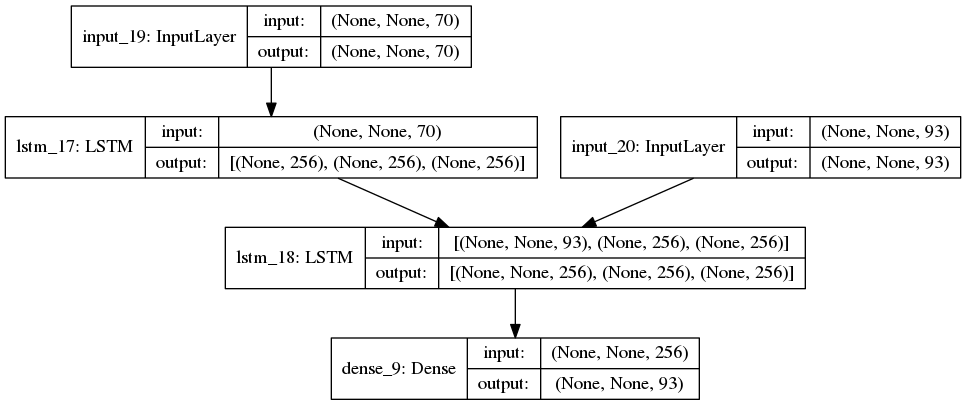

In [52]:
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG, Image
plot_model(model, to_file=r"seq_to_seq_model.png", show_shapes=True)
Image(r"seq_to_seq_model.png")


In [54]:
hist = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=100,
          validation_split=0.1)
# Save model
model.save('s2s.h5')


Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 15s 2ms/step - loss: 0.0548 - acc: 0.3026 - val_loss: 0.7145 - val_acc: 0.2345
Epoch 2/100
9000/9000 [==============================] - 15s 2ms/step - loss: 0.0543 - acc: 0.3027 - val_loss: 0.7173 - val_acc: 0.2345
Epoch 3/100
9000/9000 [==============================] - 15s 2ms/step - loss: 0.0535 - acc: 0.3029 - val_loss: 0.7158 - val_acc: 0.2341
Epoch 4/100
9000/9000 [==============================] - 15s 2ms/step - loss: 0.0528 - acc: 0.3032 - val_loss: 0.7206 - val_acc: 0.2342
Epoch 5/100
9000/9000 [==============================] - 15s 2ms/step - loss: 0.0523 - acc: 0.3035 - val_loss: 0.7256 - val_acc: 0.2338
Epoch 6/100
9000/9000 [==============================] - 15s 2ms/step - loss: 0.0521 - acc: 0.3033 - val_loss: 0.7270 - val_acc: 0.2355
Epoch 7/100
9000/9000 [==============================] - 15s 2ms/step - loss: 0.0511 - acc: 0.3037 - val_loss: 0.7202 - val_acc: 0.2345


9000/9000 [==============================] - 15s 2ms/step - loss: 0.0335 - acc: 0.3085 - val_loss: 0.8128 - val_acc: 0.2345
Epoch 61/100
9000/9000 [==============================] - 15s 2ms/step - loss: 0.0336 - acc: 0.3085 - val_loss: 0.8126 - val_acc: 0.2339
Epoch 62/100
9000/9000 [==============================] - 15s 2ms/step - loss: 0.0332 - acc: 0.3086 - val_loss: 0.8207 - val_acc: 0.2340
Epoch 63/100
9000/9000 [==============================] - 15s 2ms/step - loss: 0.0334 - acc: 0.3087 - val_loss: 0.8184 - val_acc: 0.2343
Epoch 64/100
9000/9000 [==============================] - 15s 2ms/step - loss: 0.0330 - acc: 0.3087 - val_loss: 0.8220 - val_acc: 0.2324
Epoch 65/100
9000/9000 [==============================] - 15s 2ms/step - loss: 0.0330 - acc: 0.3086 - val_loss: 0.8213 - val_acc: 0.2339
Epoch 66/100
9000/9000 [==============================] - 15s 2ms/step - loss: 0.0326 - acc: 0.3088 - val_loss: 0.8229 - val_acc: 0.2336
Epoch 67/100
9000/9000 [==============================

/home/joe/tensorflow_p3/lib/python3.5/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_18 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_17/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_17/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


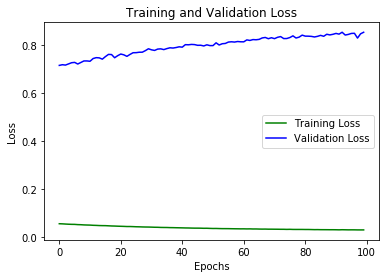

In [59]:
import matplotlib.pyplot as plt

history_dict = hist.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']


plt.plot(list(range(epochs)), loss_values, 'g', label='Training Loss')
plt.plot(list(range(epochs)), val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

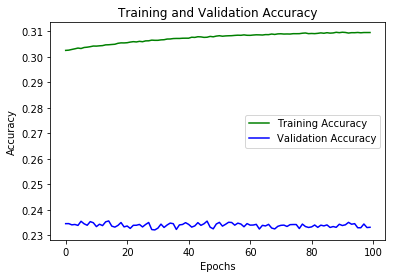

In [61]:
plt.clf()

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(list(range(epochs)), acc_values, 'g', label='Training Accuracy')
plt.plot(list(range(epochs)), val_acc_values, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [9]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


In [10]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


In [11]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Va !

-
Input sentence: Hi.
Decoded sentence: Salut !

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Who?
Decoded sentence: Qui ?

-
Input sentence: Wow!
Decoded sentence: Ça alors !

-
Input sentence: Fire!
Decoded sentence: Au feu !

-
Input sentence: Help!
Decoded sentence: À l'aide !

-
Input sentence: Jump.
Decoded sentence: Saute.

-
Input sentence: Stop!
Decoded sentence: Stop !

-
Input sentence: Stop!
Decoded sentence: Stop !

-
Input sentence: Stop!
Decoded sentence: Stop !

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: Go on.
Decoded sentence: Poursuivez.

-
Input sentence: Go on.
Decoded sentence: Poursuivez.

-
Input sentence: Go on.
Decoded sentence: Poursuivez.

-
Input sentence: Hello!
Decoded sentence: Bonjour !

-
Input sentence: Hello!
Decoded sentence: Bonjour !

-
Input senten